In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import CSVLogger, Callback
import keras.backend as K
import os

In [2]:
# Get current working directory
cwd = pathlib.Path.cwd()

In [3]:
# Load data from cwd
ds1, ds2, ds3 = tfds.load('patch_camelyon', split=['train[:30%]', 'test[:7%]', 'validation[:7%]'], #-----------------------------
                                data_dir=cwd, 
                                download=False, 
                                shuffle_files=True)

In [4]:
# load the model from file
encoder = tf.keras.models.load_model('low_ae_encoder.h5') # don't recall the name so might need to change this

# Print the encoder summary
print(encoder.summary())


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 16)       64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 32)        0   

In [5]:
num_classes = 2
batch_size = 32

def preprocess_encode_and_label(sample):
    # Preprocess the image
    image = tf.image.convert_image_dtype(sample['image'], tf.float32)
    image = tf.image.resize(image, [96, 96])

    # Add a batch dimension
    image = tf.expand_dims(image, 0)

    # Encode the image using the trained encoder
    encoded_image = encoder(image, training=False)

    # Remove the batch dimension
    encoded_image = tf.squeeze(encoded_image, 0)

    # One-hot encode the label
    label = tf.one_hot(sample['label'], num_classes, dtype=tf.float32)

    return encoded_image, label

# Apply the function to your datasets
encoded_classifier_train_dataset = ds1.map(preprocess_encode_and_label).batch(batch_size)
encoded_classifier_val_dataset = ds2.map(preprocess_encode_and_label).batch(batch_size)
encoded_classifier_test_dataset = ds3.map(preprocess_encode_and_label).batch(batch_size)


In [6]:
encoded_shape = (24,24,64) # shape of the output of the encoder


Model with no regularization

In [7]:
# Create a new CNN model
cnn_base_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=encoded_shape),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
], name = 'cnn_base_model')


Model with dropout

In [8]:
cnn_dropout = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=encoded_shape),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
], name = 'cnn_dropout')

Model with L2 regularization

In [9]:
cnn_l2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=encoded_shape),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(2, activation='softmax')
], name = 'cnn_l2')



Model with L1 regularization

In [10]:
cnn_l1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=encoded_shape),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(2, activation='softmax')
], name = 'cnn_l1')



Multi regularization 

In [11]:
cnn_multi_reg = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=encoded_shape),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
], name = 'cnn_multi')



In [12]:
def evaluate_model_and_save_predictions(cnn_model, test_dataset):
    """
    Evaluates the given CNN model on the test dataset and saves predictions to a CSV file.

    :param cnn_model: The trained CNN model.
    :param test_dataset: The test dataset, assumed to be batched and prefetched.
    :return: Accuracy of the model on the test dataset.
    """
    # Generate predictions
    predictions = cnn_model.predict(test_dataset)

    # Convert predictions to class indices
    predicted_labels = np.argmax(predictions, axis=1)

    # Save predictions to CSV
    predictions_pd = pd.DataFrame({'Id': list(range(len(predicted_labels))), 'Predicted': predicted_labels})

    # Gather true labels
    true_labels = []
    for _, labels in test_dataset.unbatch().take(len(predicted_labels)):
        true_labels.append(labels.numpy())
    true_labels = np.array(true_labels)

    # Convert one-hot encoded labels to class indices if necessary
    if true_labels.ndim > 1:
        true_labels = np.argmax(true_labels, axis=1)

    # Calculate accuracy
    accuracy = np.mean(predicted_labels == true_labels)
    return f"Accuracy: {accuracy * 100:.2f}%"


In [ ]:
models = [cnn_base_model, cnn_dropout, cnn_l2, cnn_l1, cnn_multi_reg]

model_histories = {}
model_test_accuracy = []

for model in models:
    print('Model name: ', model.name)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    # Train the model and save the history
    history = model.fit(encoded_classifier_train_dataset, epochs=25, validation_data=encoded_classifier_val_dataset)
    model_histories[model.name] = history.history

    # Evaluate the model on the test dataset
    test_accuracy = evaluate_model_and_save_predictions(model, encoded_classifier_test_dataset)
    model_test_accuracy.append(test_accuracy)

# Save the test accuracies to a CSV file
test_acc_df = pd.DataFrame(model_test_accuracy)
test_acc_csv_file = 'test_accuracy.csv'
test_acc_df.to_csv(test_acc_csv_file)


Model name:  cnn_base_model
Epoch 1/25
2458/2458 [==============================] - 322s 131ms/step - loss: 0.3993 - accuracy: 0.8224 - val_loss: 0.5225 - val_accuracy: 0.7463
Epoch 2/25
2458/2458 [==============================] - 346s 141ms/step - loss: 0.3629 - accuracy: 0.8424 - val_loss: 0.5193 - val_accuracy: 0.7524
Epoch 3/25
2458/2458 [==============================] - 333s 135ms/step - loss: 0.3384 - accuracy: 0.8547 - val_loss: 0.5987 - val_accuracy: 0.7302
Epoch 4/25
2458/2458 [==============================] - 345s 140ms/step - loss: 0.3176 - accuracy: 0.8665 - val_loss: 0.5604 - val_accuracy: 0.7563
Epoch 5/25
2458/2458 [==============================] - 340s 138ms/step - loss: 0.2960 - accuracy: 0.8773 - val_loss: 0.7520 - val_accuracy: 0.7214
Epoch 6/25
2458/2458 [==============================] - 336s 137ms/step - loss: 0.2746 - accuracy: 0.8853 - val_loss: 0.6933 - val_accuracy: 0.7354
Epoch 7/25
2458/2458 [==============================] - 334s 136ms/step - loss: 0.25

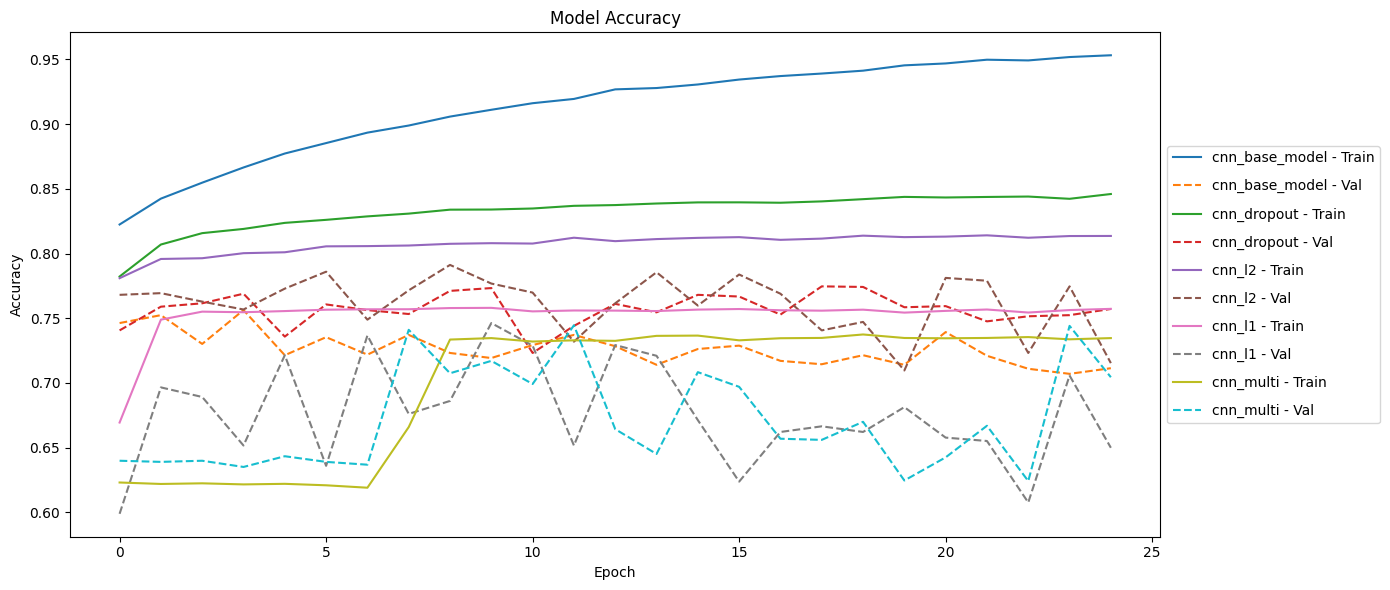

In [17]:
plt.figure(figsize=(14, 6))
for name, history in model_histories.items():
    plt.plot(history['accuracy'], label=f'{name} - Train')
    plt.plot(history['val_accuracy'], label=f'{name} - Val', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1)
plt.tight_layout()
plt.show()


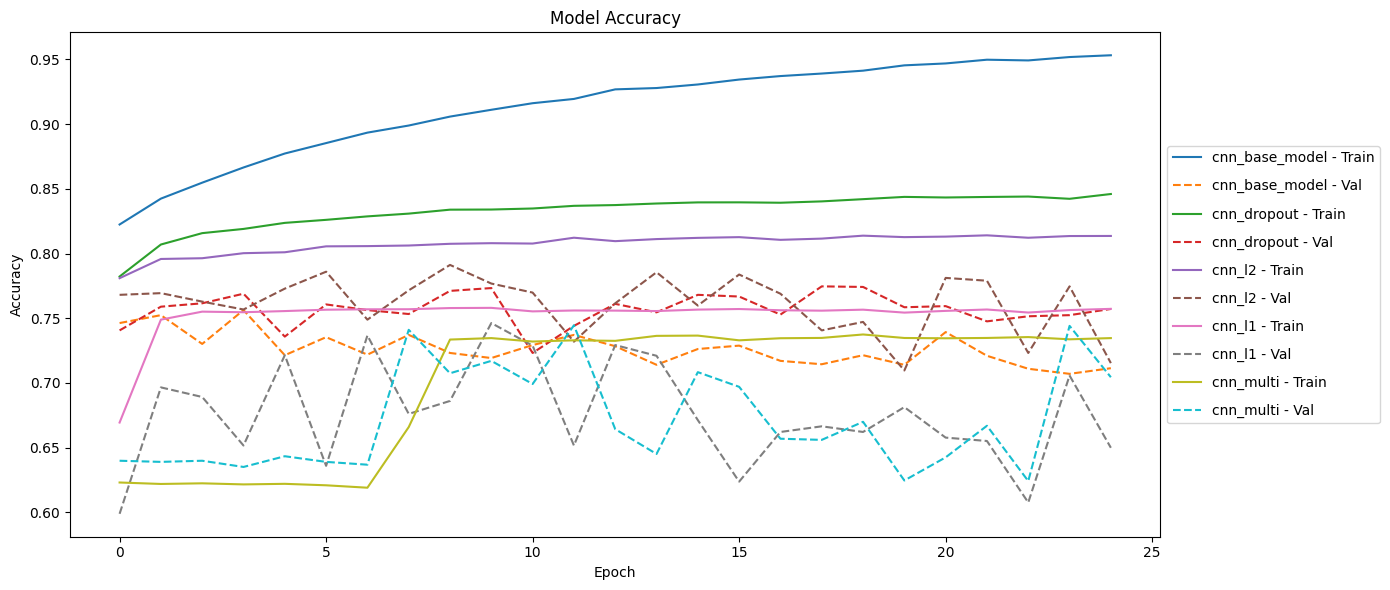

In [19]:
plt.figure(figsize=(14, 6))
for name, history in model_histories.items():
    plt.plot(history['accuracy'], label=f'{name} - Train')
    plt.plot(history['val_accuracy'], label=f'{name} - Val', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1)
plt.tight_layout()
plt.savefig('models_accuracy.png')
plt.show()


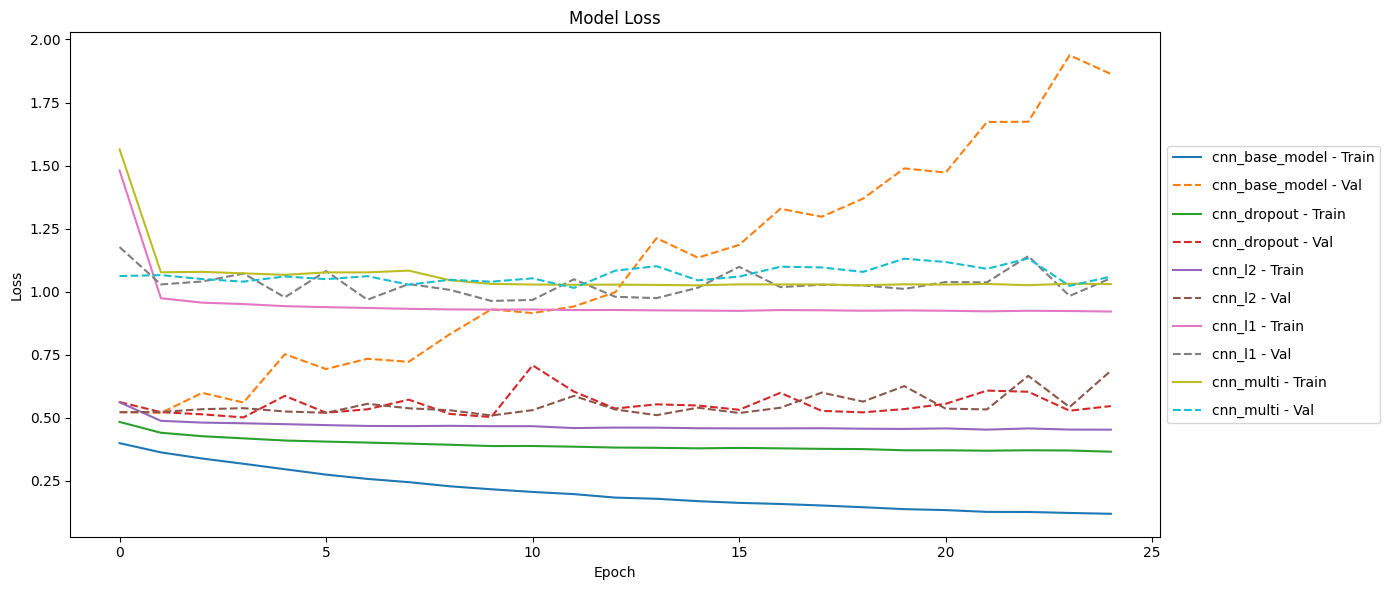

In [20]:
plt.figure(figsize=(14, 6))
for name, history in model_histories.items():
    plt.plot(history['loss'], label=f'{name} - Train')
    plt.plot(history['val_loss'], label=f'{name} - Val', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1)
plt.tight_layout()
plt.savefig('models_loss.png')
plt.show()
